# Housekeeping

In [57]:
if False:
    import sys
    !{sys.executable} -m pip install -r requirements.txt

## Library Imports

In [58]:
# Core Libraries
import pandas as pd
from colorama import Fore, Style
import warnings
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn import set_config

# Statistical & Data Processing
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Custom Functions
from functions import set_global_seeds, MASTER_SEED


## Settings

In [59]:
warnings.filterwarnings("ignore")
set_config(transform_output="pandas")
print(Style.RESET_ALL)
# Set global random seeds for reproducibility
set_global_seeds(MASTER_SEED)


Global seeds set to 3004


## Data Import

In [60]:
data = pd.read_csv('../data/raw/MAI3004_lucki_mpa411.csv')
metadata = pd.read_csv('../data/raw/MAI3004_lucki_metadata_safe.csv')
print(
    f"Data successfully imported. \n shape of data: {data.shape} \n "
    f"Shape of metadata: {metadata.shape}"
)

assert data.shape == (6903, 932), "Data has the wrong shape. Check the CSV formatting."
assert metadata.shape == (930, 6), "Metadata has the wrong shape. Check the CSV formatting."

Data successfully imported. 
 shape of data: (6903, 932) 
 Shape of metadata: (930, 6)


# Data Preprocessing

## Merge Data and Metadata

In [61]:
sample_cols = [col for col in data.columns if col.startswith("mpa411_")]

sample_abundances = (
    data[['clade_name'] + sample_cols]
    .set_index('clade_name')
    .transpose()
    .rename_axis('original_sample_id')
    .reset_index()
    .rename(columns={'original_sample_id': 'sample_id'})
)

sample_abundances["sample_id"] = (
    sample_abundances["sample_id"].str.removeprefix(
        "mpa411_",
    )
)

metadata_common = metadata[
    metadata["sample_id"].isin(sample_abundances["sample_id"])
].copy()
merged_samples = metadata_common.merge(
    sample_abundances,
    on="sample_id",
    how="inner",
)

merged_samples.drop(columns=['year_of_birth', 'body_product'], inplace=True)

print(f"Metadata rows (original): {metadata.shape[0]}")
print(f"Metadata rows with matching samples: {metadata_common.shape[0]}")
print(
    f"Metadata rows without matching samples: "
    f"{metadata_common.shape[0]-metadata_common.shape[0]}"
)
print(f"Merged dataframe shape: {merged_samples.shape}")

Metadata rows (original): 930
Metadata rows with matching samples: 930
Metadata rows without matching samples: 0
Merged dataframe shape: (930, 6907)


In [62]:
merged_samples.head()

,sample_id,family_id,sex,age_group_at_sample,UNCLASSIFIED,k__Bacteria,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Candidatus_Saccharibacteria,...,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03|t__SGB4260,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033|t__SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061|t__SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528|t__SGB6528
0,MMHP_Lucki_0001,ENA_fam_0139,female,1-2 weeks,11.15024,88.849765,51.309655,0.002106,34.721253,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MMHP_Lucki_0002,ENA_fam_0139,female,NaN,13.65529,86.284502,4.551376,0.041143,71.819009,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MMHP_Lucki_0003,ENA_fam_0136,female,1-2 weeks,20.33656,79.663440,64.794124,10.664824,0.526129,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MMHP_Lucki_0004,ENA_fam_0136,female,NaN,11.30536,88.694643,11.944587,0.284914,73.876500,0.00259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MMHP_Lucki_0005,ENA_fam_0136,female,4 weeks,21.67587,78.324133,57.245464,18.558613,0.918946,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Encoding

In [63]:
# Sex and family_ID
encoded_samples = merged_samples.copy().dropna(subset="age_group_at_sample")

encoded_samples["sex"] = (
    encoded_samples["sex"]
    .fillna("unknown")
    .replace({"female": 1, "male": 0, "unknown": 2})
)
encoded_samples["family_id"] = LabelEncoder().fit_transform(
    encoded_samples["family_id"]
)

In [64]:
#Using days to better interpret the distance between age groups
encoding_guide = {
    '1-2 weeks': 10,
    '4 weeks': 28,
    '8 weeks': 56,
    '4 months': 120,
    '5 months': 150,
    '6 months': 180,
    '9 months': 270,
    '11 months': 330,
    '14 months': 420,
}
encoded_samples["age_group_at_sample"] = encoded_samples["age_group_at_sample"].replace(encoding_guide)
encoded_samples["age_group_at_sample"] = encoded_samples["age_group_at_sample"].astype(int)
# consider in interpretation that the distances between the real age bins are not the same as our age groups

In [65]:
leftovers = encoded_samples[encoded_samples["age_group_at_sample"].apply(lambda x: isinstance(x, str))]

if not leftovers.empty:

    print("Age group encoding:", leftovers["age_group_at_sample"].unique())

else:
    print("Fallback encoding not needed")


Fallback encoding not needed


### Saving Encoded Data for Model use

In [66]:
#Create the directory if it does not exist
os.makedirs('processed_data', exist_ok=True)
#Save the encoded samples as csv for Model notebooks use
encoded_samples.to_csv('processed_data/encoded_samples.csv', index=False)

## Missing Check

In [67]:
missing_table = (
    encoded_samples.isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(
        missing_percent=lambda df: (
            (df["missing_count"] / encoded_samples.shape[0] * 100).round(2)
        ),
    )
    .reset_index()
    .rename(columns={"index": "column"})
    .sort_values("missing_count", ascending=False)
    .query("missing_count != 0")
)

if len(missing_table) > 0:
    print(missing_table)
else:
    print("No missing values detected.")

No missing values detected.


## Outlier Check

In [68]:
numeric_cols = encoded_samples.select_dtypes(include=[np.number]).columns

q1 = encoded_samples[numeric_cols].quantile(0.25)
q3 = encoded_samples[numeric_cols].quantile(0.75)
iqr = q3 - q1

lower_bounds = q1 - 1.5 * iqr
upper_bounds = q3 + 1.5 * iqr

outlier_mask = (
    (encoded_samples[numeric_cols] < lower_bounds)
    | (encoded_samples[numeric_cols] > upper_bounds)
)
outlier_counts = outlier_mask.sum()
outlier_percent = (outlier_counts / encoded_samples.shape[0] * 100).round(2)

outlier_table = (
    pd.DataFrame({
        "column": numeric_cols,
        "lower_bound": lower_bounds,
        "upper_bound": upper_bounds,
        "outlier_count": outlier_counts,
        "outlier_percent": outlier_percent,
    })
    .query("outlier_count > 0")
    .sort_values("outlier_percent", ascending=False)
    .reset_index(drop=True)
)

outlier_table

,column,lower_bound,upper_bound,outlier_count,outlier_percent
0,k__Bacteria|p__Actinobacteria|c__Actinomycetia...,0.000000,0.000000,201,24.88
1,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0.000000,0.000000,201,24.88
2,k__Bacteria|p__Verrucomicrobia,-0.000195,0.000325,200,24.75
3,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,0.000000,0.000000,198,24.50
4,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacill...,0.000000,0.000000,198,24.50
...,...,...,...,...,...
5155,k__Bacteria|p__Firmicutes|c__CFGB1765|o__OFGB1...,0.000000,0.000000,1,0.12
5156,k__Bacteria|p__Firmicutes|c__CFGB3054|o__OFGB3...,0.000000,0.000000,1,0.12
5157,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eub...,0.000000,0.000000,1,0.12
5158,k__Bacteria|p__Firmicutes|c__CFGB1425|o__OFGB1...,0.000000,0.000000,1,0.12


## Normalisation Check

In [69]:
print("Shapiro-Wilk Normality Test")

for column in numeric_cols:
    data_nona = encoded_samples[column].dropna()
    stat, p_value = stats.shapiro(data_nona)

    if p_value > 0.05:
        print(Fore.GREEN + f"{column}: Normally Distributed (p={p_value:.4f})")

    else:
        print(
            Fore.RED
            + f"{column}: Not Normally Distributed (p={p_value:.4f})"
        )

print(Style.RESET_ALL)

Shapiro-Wilk Normality Test
family_id: Not Normally Distributed (p=0.0000)
sex: Not Normally Distributed (p=0.0000)
age_group_at_sample: Not Normally Distributed (p=0.0000)
UNCLASSIFIED: Not Normally Distributed (p=0.0000)
k__Bacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Actinobacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Proteobacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Candidatus_Saccharibacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Bacteroidota: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Actinobacteria|c__Actinomycetia: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes|c__Negativicutes: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes|c__Clostridia: Not Normally Distributed (p=0.0000)
k__Bacteria|p__Firmicutes|c__Bacilli: Not Normally Dist

# Exploratory data analysis

In [70]:
print(merged_samples.shape)
merged_samples.head()

(930, 6907)


,sample_id,family_id,sex,age_group_at_sample,UNCLASSIFIED,k__Bacteria,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Firmicutes,k__Bacteria|p__Candidatus_Saccharibacteria,...,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528,k__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Ruminococcus|s__Ruminococcus_sp_210702_SL_1_03|t__SGB4260,k__Bacteria|p__Bacteroidota|c__CFGB77857|o__OFGB77857|f__FGB77857|g__GGB12893|s__GGB12893_SGB20033|t__SGB20033,k__Bacteria|p__Firmicutes|c__CFGB1474|o__OFGB1474|f__FGB1474|g__GGB51269|s__GGB51269_SGB5061|t__SGB5061,k__Bacteria|p__Firmicutes|c__CFGB1778|o__OFGB1778|f__FGB1778|g__GGB4714|s__GGB4714_SGB6528|t__SGB6528
0,MMHP_Lucki_0001,ENA_fam_0139,female,1-2 weeks,11.15024,88.849765,51.309655,0.002106,34.721253,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MMHP_Lucki_0002,ENA_fam_0139,female,NaN,13.65529,86.284502,4.551376,0.041143,71.819009,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MMHP_Lucki_0003,ENA_fam_0136,female,1-2 weeks,20.33656,79.663440,64.794124,10.664824,0.526129,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MMHP_Lucki_0004,ENA_fam_0136,female,NaN,11.30536,88.694643,11.944587,0.284914,73.876500,0.00259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MMHP_Lucki_0005,ENA_fam_0136,female,4 weeks,21.67587,78.324133,57.245464,18.558613,0.918946,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dataset overview

In [71]:

print("Number of samples:", len(merged_samples))
print(
    "Number of unique families (family_id):",
    merged_samples["family_id"].nunique(),
)
print("Number of columns (metadata + features):", merged_samples.shape[1])

Number of samples: 930
Number of unique families (family_id): 139
Number of columns (metadata + features): 6907


## Samples per family

In [72]:

samples_per_family = merged_samples["family_id"].value_counts()
samples_per_family.describe()

count    139.000000
mean       6.690647
std        2.232335
min        1.000000
25%        5.500000
50%        7.000000
75%        8.000000
max       11.000000
Name: count, dtype: float64

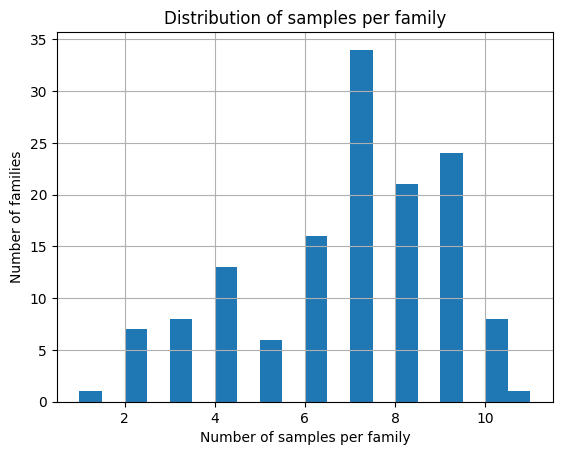

In [73]:
samples_per_family.hist(bins=20)
plt.xlabel("Number of samples per family")
plt.ylabel("Number of families")
plt.title("Distribution of samples per family")
plt.show()

## Distribution of Age Groups

In [74]:
merged_samples["age_group_at_sample"].value_counts(dropna=False)

age_group_at_sample
NaN          122
8 weeks      105
4 months     103
5 months      96
9 months      92
6 months      88
1-2 weeks     84
11 months     83
4 weeks       82
14 months     75
Name: count, dtype: int64

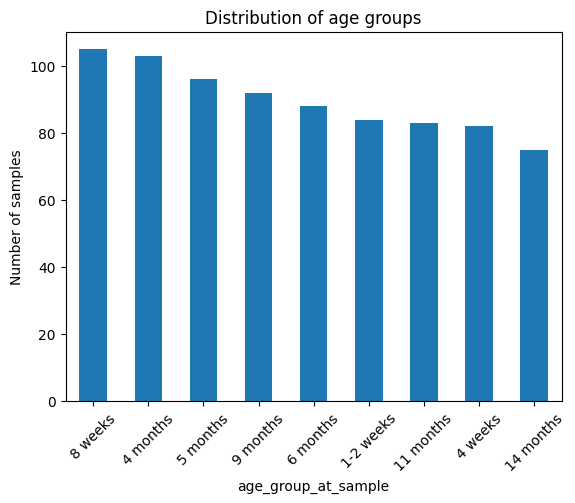

In [75]:
merged_samples["age_group_at_sample"].value_counts().plot(kind="bar")
plt.title("Distribution of age groups")
plt.ylabel("Number of samples")
plt.xticks(rotation=45)
plt.show()

## Dimensionality and Sparsity of the Microbiome Feature Matrix

In [76]:
metadata_cols = [
    "sample_id",
    "family_id",
    "sex",
    "body_product",
    "age_group_at_sample",
    "year_of_birth",
]
feature_cols = [c for c in merged_samples.columns if c not in metadata_cols]

microbiome_data = merged_samples[feature_cols]

print("Feature matrix shape:", microbiome_data.shape)
print("Overall fraction of zeros:", (microbiome_data == 0).mean().mean())

Feature matrix shape: (930, 6903)
Overall fraction of zeros: 0.9556136571445484


## Observed Taxa per sample

In [77]:
#number of observed taxa per sample
nonzero_per_sample = (microbiome_data > 0).sum(axis=1)
nonzero_per_sample.describe()

count     930.000000
mean      306.398925
std       338.629879
min        46.000000
25%       127.000000
50%       181.000000
75%       282.000000
max      1821.000000
dtype: float64

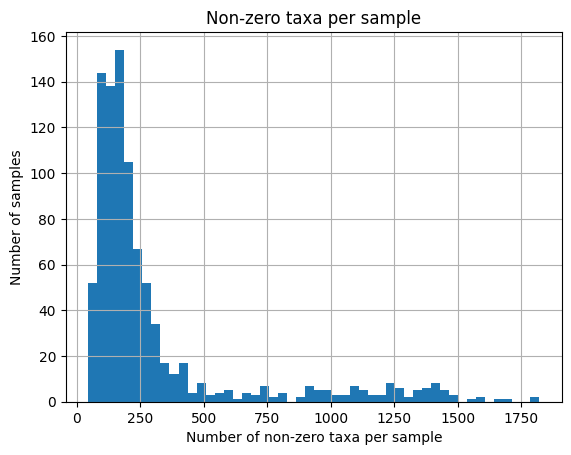

In [78]:
nonzero_per_sample.hist(bins=50)
plt.xlabel("Number of non-zero taxa per sample")
plt.ylabel("Number of samples")
plt.title("Non-zero taxa per sample")
plt.show()

## Total Abundance per sample

In [79]:
total_abundance = microbiome_data.sum(axis=1)
total_abundance.describe()

count    930.000000
mean     704.546050
std       64.838116
min      337.616534
25%      676.683539
50%      715.251764
75%      749.225950
max      800.000170
dtype: float64

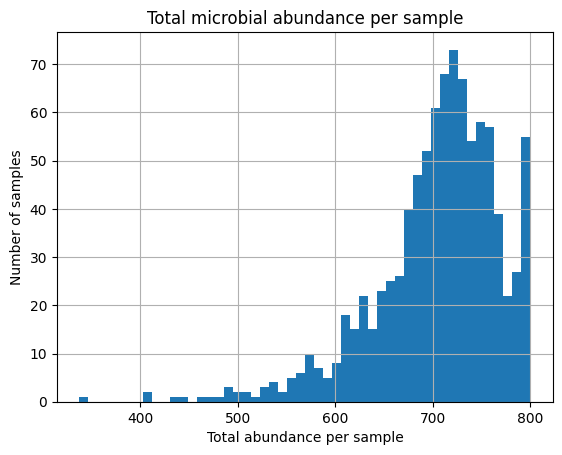

In [80]:
total_abundance.hist(bins=50)
plt.xlabel("Total abundance per sample")
plt.ylabel("Number of samples")
plt.title("Total microbial abundance per sample")
plt.show()

## Distribution of Features Prevalence

In [81]:
feature_prevalence = (microbiome_data > 0).sum(axis=0)
feature_prevalence.describe()

count    6903.000000
mean       41.279299
std        96.983595
min         1.000000
25%         2.000000
50%         9.000000
75%        38.000000
max       930.000000
dtype: float64

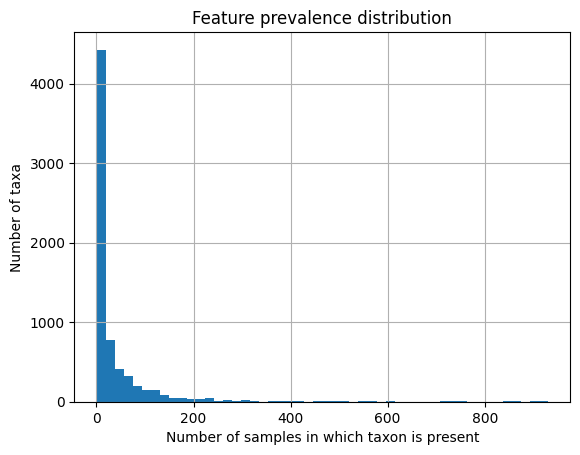

In [82]:
feature_prevalence.hist(bins=50)
plt.xlabel("Number of samples in which taxon is present")
plt.ylabel("Number of taxa")
plt.title("Feature prevalence distribution")
plt.show()

## Distribution of non-zero Abundances (log scale)

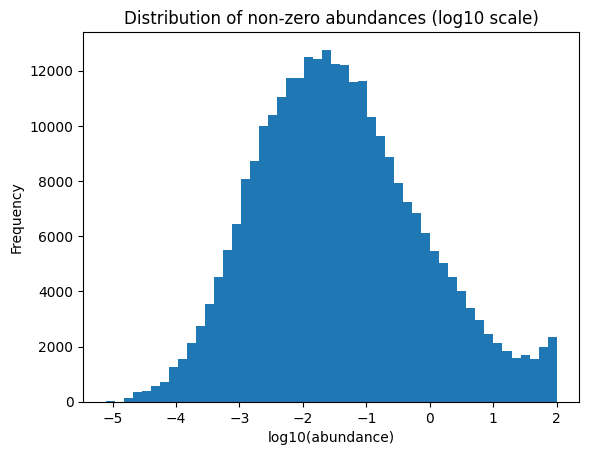

In [83]:
nonzero_values = microbiome_data.values[microbiome_data.values > 0]
plt.hist(np.log10(nonzero_values), bins=50)
plt.xlabel("log10(abundance)")
plt.ylabel("Frequency")
plt.title("Distribution of non-zero abundances (log10 scale)")
plt.show()

## PCA Visualisation

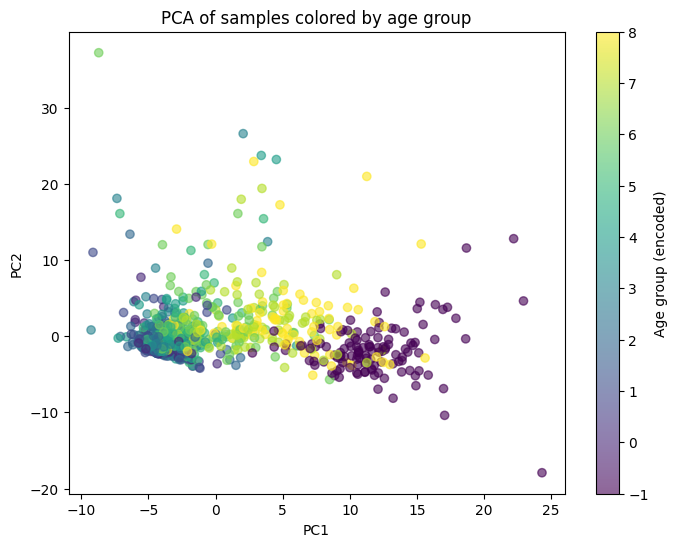

Explained variance ratio: [0.07129799 0.02968984]


In [84]:
# Use a subset of features for speed
prevalence = (microbiome_data > 0).sum(axis=0)
top_features = prevalence.sort_values(ascending=False).head(500).index

microbiome_data_sub = microbiome_data[top_features]

# Scale features
microbiome_data_scaled = StandardScaler().fit_transform(microbiome_data_sub)

# PCA
pca = PCA(n_components=2)
microbiome_data_pca = pca.fit_transform(microbiome_data_scaled)

# Plot
age = merged_samples["age_group_at_sample"]

plt.figure(figsize=(8,6))
plt.scatter(microbiome_data_pca.iloc[:, 0], microbiome_data_pca.iloc[:, 1],
            c=pd.factorize(age)[0], cmap="viridis", alpha=0.6)
plt.colorbar(label="Age group (encoded)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of samples colored by age group")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

# EDA Summary

The dataset consists of 930 stool samples derived from multiple individuals across different families and contains approximately 6,900 microbiome features, making it a high-dimensional and highly sparse dataset. Each sample contains on average around 300 detected taxa, while the total microbial abundance per sample is relatively stable, indicating that sequencing depth is relatively consistent across samples.

Most taxa are rare and occur in only a small fraction of samples, whereas a small subset of taxa is highly prevalent across the cohort. The distribution of non-zero abundances follows an approximately log-normal shape, which is typical for microbiome sequencing data (Lutz et al., 2022).

An initial PCA projection based on the most prevalent taxa and raw abundance data does not reveal sharply separated clusters but shows a gradual age-related gradient, suggesting that age-related variation in microbiome composition is present but represents only a limited fraction of the total variance in the data.

Because microbiome data are compositional in nature, a second PCA is later performed on CLR-transformed and standardized data in the preprocessing stage to obtain a compositionally valid low-dimensional representation for downstream analysis and modeling.
